## ***Problem we are solving : To explore a framework that can resist adversarial phishing websites crafted using Generative Adversarial Networks (GANs). This research will focus on improving robustness through adversarial training combined with multi-modal feature extraction (e.g., URL, HTML content, metadata).***

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [ ]:
# to stay away from warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# necessary packages to include for data manipulations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# packages for training the model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score
import torch.optim as optim
import torch.nn as nn
import torch

Load the preprocessed dataset

In [ ]:
# load the data to a dataframe
df = pd.read_csv('/content/url_processed.csv')

In [ ]:
# explore the data loaded on to the system - "head" prints first 5 instances of data
df.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,0,0,1,0,0,1,0,0
4,icicibank.com,0,0,1,3,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
# checking the dimension of dataset we included
df.shape

(10000, 17)

In [ ]:
# checking for null values
df.isnull().sum()

,0
Domain,0
Have_IP,0
Have_At,0
URL_Length,0
URL_Depth,0
Redirection,0
https_Domain,0
TinyURL,0
Prefix/Suffix,0
DNS_Record,0


Install the required package

In [ ]:
!pip install tensorflow

Explore phishing and legitimate data


*   Drop the column 'Domain'
*   Inspect the data view



In [ ]:
# Load the datasets
legitimate = pd.read_csv('/content/legitimate.csv')
phishing = pd.read_csv('/content/phishing.csv')


legitimate_data = legitimate.drop(columns=['Domain'])
phishing_data = phishing.drop(columns=['Domain'])

# Display the structure of the datasets
print("Legitimate Data:")
print(legitimate_data.head())
print("\nPhishing Data:")
print(phishing_data.head())


Legitimate Data:
   Have_IP  Have_At  URL_Length  URL_Depth  Redirection  https_Domain  \
0        0        0           1          1            0             0   
1        0        0           1          1            1             0   
2        0        0           1          1            0             0   
3        0        0           1          3            0             0   
4        0        0           1          3            0             0   

   TinyURL  Prefix/Suffix  DNS_Record  Domain_Age  Domain_End  iFrame  \
0        0              0           0           1           1       0   
1        0              0           0           1           1       0   
2        0              0           0           0           1       0   
3        0              0           0           0           1       0   
4        0              0           0           0           1       0   

   Mouse_Over  Right_Click  Web_Forwards  Label  
0           0            1             0      0  
1    

In [ ]:
phishing_data

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1
1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1
2,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,1
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,1,5,0,0,1,1,0,1,1,0,0,1,0,1
4996,0,0,1,4,0,0,0,0,0,0,1,0,0,1,0,1
4997,0,1,1,3,0,0,1,0,0,1,1,1,0,1,0,1
4998,0,0,1,5,0,0,1,1,0,1,1,0,0,1,0,1


In [ ]:
legitimate_data.shape

(5000, 16)

### *GAN Implementation*

In [ ]:
# Load the datasets
phishing = pd.read_csv('/content/phishing.csv')
legitimate = pd.read_csv('/content/legitimate.csv')

phishing_data = phishing.drop(columns=['Domain'])
legitimate_data = legitimate.drop(columns=['Domain'])

# Convert data to numpy arrays
data_phishing = phishing_data.to_numpy()
data_legitimate = legitimate_data.to_numpy()

# Set the device to CUDA if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Define Generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

# Define Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Function to train GAN and generate samples
def train_gan(data, data_columns, output_file, num_epochs=10000, batch_size=64, latent_dim=100):
    data_dim = data.shape[1]
    generator = Generator(latent_dim, data_dim).to(device)
    discriminator = Discriminator(data_dim).to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
    adversarial_loss = nn.BCELoss()

    dataset = CustomDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for real_samples in dataloader:
            batch_size = real_samples.size(0)
            real_samples = real_samples.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            d_loss_real = adversarial_loss(discriminator(real_samples), real_labels)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = generator(z)
            d_loss_fake = adversarial_loss(discriminator(fake_samples), fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            z = torch.randn(batch_size, latent_dim).to(device)
            generated_samples = generator(z)
            g_loss = adversarial_loss(discriminator(generated_samples), real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")
        if epoch == 500:
            print("Trained successfully")
            break

    # Generate new samples
    z = torch.randn(2000, latent_dim).to(device)
    generated_samples = generator(z).detach().cpu().numpy()
    binary_samples = (generated_samples > 0.5).astype(int)
    generated_df = pd.DataFrame(binary_samples, columns=data_columns)
    generated_df.to_csv(output_file, index=False)

# Train GAN for phishing and legitimate data
train_gan(data_phishing, phishing_data.columns, 'GAN_phishing_samples.csv')
train_gan(data_legitimate, legitimate_data.columns, 'GAN_legitimate_samples.csv')


In [ ]:
gan_legitimate = pd.read_csv('/content/GAN_legitimate_samples.csv')
gan_phishing = pd.read_csv('/content/GAN_phishing_samples.csv')

In [ ]:
phishing = phishing.drop(['Domain'], axis=1).copy()
legitimate = legitimate.drop(['Domain'], axis=1).copy()

In [ ]:
combined_phishing = pd.concat([phishing, gan_phishing], ignore_index=True)
combined_legitimate = pd.concat([legitimate, gan_legitimate], ignore_index=True)

In [ ]:
combined_phishing

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1
1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1
2,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,1
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1
6996,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1
6997,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,1
6998,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,1


In [ ]:
combined_legitimate

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0
1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0
2,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,1,3,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,1,3,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
6996,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
6997,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
6998,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0


In [ ]:
combined_overall_df = pd.concat([combined_phishing, combined_legitimate], ignore_index=True)
combined_overall_df

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1
1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1
2,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,1
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
13996,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
13997,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0
13998,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0


Using train_test_split for combined dataset and training the model

In [ ]:
X = combined_overall_df.drop(['Label','Domain'],axis=1)
Y = combined_overall_df['Label']

In [ ]:
# training data using traditional ml model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(14000, 15) (11200, 15) (2800, 15)


### Model Training

**Traditional Machine Learning Models: The following models are trained and evaluated:**

* Logistic Regression
* Decision Tree
* Random Forest
* Support Vector Machine (SVM)
* Naive Bayes
* Gradient Boosting Machine (GBM)

These models are widely used in classification tasks and serve as a baseline for comparison against more advanced methods.

**Advanced Ensemble Methods**: The code also includes methods to train and evaluate three powerful ensemble models:

**XGBoost**: A gradient boosting algorithm known for its speed and performance.
**LightGBM**: A faster, more efficient gradient boosting method that excels with large datasets.
**CatBoost**: A gradient boosting library optimized for categorical features and high performance.

Each of these models is trained using specialized parameters and evaluated similarly to the traditional models.

**Model Evaluation**: For each model, the accuracy and classification report are printed. These metrics help assess the model's effectiveness in classifying the data accurately, considering the balance between different types of errors (false positives vs. false negatives).

**Purpose:**
The primary objective is to evaluate how well different models perform in identifying phishing URLs and distinguishing them from legitimate ones. The use of various models, from traditional classifiers to advanced boosting techniques, provides insight into which algorithm works best for this specific classification task.

By comparing the results of all models, the most suitable algorithm for detecting phishing URLs can be selected based on accuracy, precision, recall, and F1-score.

In [ ]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
  ML_Model.append(model)
  acc_train.append(round(a, 3))
  acc_test.append(round(b, 3))

Logistic Regression : A linear model that estimates probabilities for classification based on a logistic function.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Train the model
log_reg_model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#predicting the target value from the model for the samples
y_test_log = log_reg_model.predict(X_test)
y_train_log = log_reg_model.predict(X_train)

Model Evaluation

In [ ]:
acc_train_log = accuracy_score(Y_train,y_train_log)
acc_test_log = accuracy_score(Y_test, y_test_log)

print("Logistic Regression: Accuracy on training data: {:.2f}".format(acc_train_log))
print("Logistic Regression: Accuracy on testing data: {:.2f}".format(acc_test_log))

Logistic Regression: Accuracy on training data: 0.95
Logistic Regression: Accuracy on testing data: 0.94


In [ ]:
storeResults('Logistic Regression', acc_train_log, acc_test_log)

Decision trees : are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision. Learning a decision tree means learning the sequence of if/else questions that gets us to the true answer most quickly.

In [ ]:
# Decision Tree model
from sklearn.tree import DecisionTreeClassifier

# instantiate the model
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model
tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
y_test_tree = tree.predict(X_test)
y_train_tree = tree.predict(X_train)

In [ ]:
acc_train_tree = accuracy_score(Y_train,y_train_tree)
acc_test_tree = accuracy_score(Y_test,y_test_tree)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree: Accuracy on training Data: 0.953
Decision Tree: Accuracy on test Data: 0.948


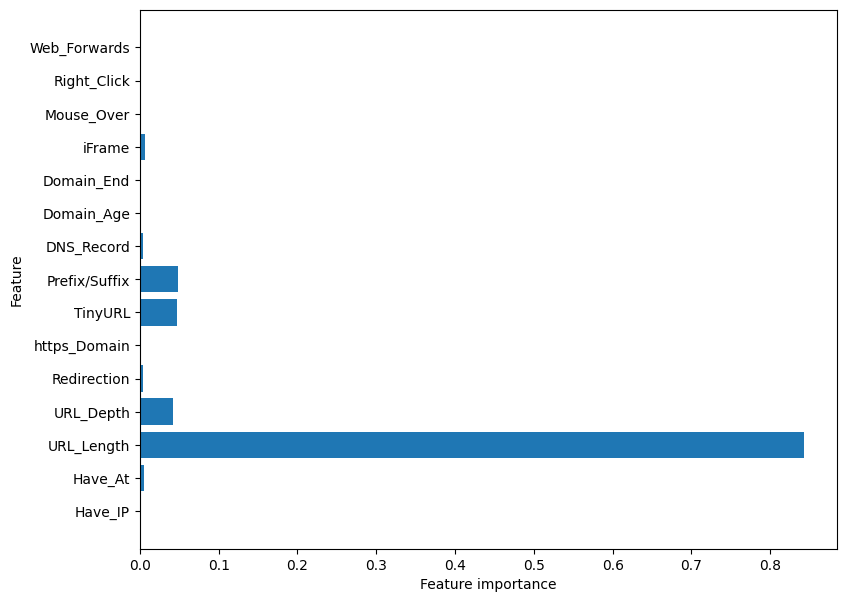

In [ ]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
storeResults('Decision Tree', acc_train_tree, acc_test_tree)

Random Forest Classifier : primarily used for classification tasks. It is built on the concept of combining multiple decision trees to make more accurate predictions.

In [ ]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5)

In [ ]:
y_test_forest = forest.predict(X_test)
y_train_forest = forest.predict(X_train)

In [ ]:
acc_train_forest = accuracy_score(Y_train,y_train_forest)
acc_test_forest = accuracy_score(Y_test,y_test_forest)

print("Random Forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))

Random Forest: Accuracy on training Data: 0.948
Random Forest: Accuracy on test Data: 0.944


In [ ]:
storeResults('Random Forest', acc_train_forest, acc_test_forest)

Support Vector Machine (SVM): A model that finds the hyperplane that best separates the data into different classes.

In [ ]:
#Support vector machine model
from sklearn.svm import SVC

# instantiate the model
svm = SVC(kernel='linear', C=1.0, random_state=12)
#fit the model
svm.fit(X_train, Y_train)

SVC(kernel='linear', random_state=12)

In [ ]:
y_test_svm = svm.predict(X_test)
y_train_svm = svm.predict(X_train)

In [ ]:
acc_train_svm = accuracy_score(Y_train,y_train_svm)
acc_test_svm = accuracy_score(Y_test,y_test_svm)

print("SVM: Accuracy on training Data: {:.3f}".format(acc_train_svm))
print("SVM : Accuracy on test Data: {:.3f}".format(acc_test_svm))

SVM: Accuracy on training Data: 0.935
SVM : Accuracy on test Data: 0.937


In [ ]:
storeResults('Support Vector Machine', acc_train_svm, acc_test_svm)

XGBoost: A highly efficient, gradient boosting algorithm known for speed and performance, often used in structured/tabular data.

In [ ]:
import xgboost as xgb

def train_xgb():
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test, label=Y_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1
    }

    # Train XGBoost model
    model_xgb = xgb.train(params, dtrain, num_boost_round=100)

    # Make predictions
    y_train_pred = model_xgb.predict(dtrain)
    y_test_pred = model_xgb.predict(dtest)

    # Convert probabilities to binary class labels (0 or 1)
    y_train_xgb = np.where(y_train_pred > 0.5, 1, 0)
    y_test_xgb = np.where(y_test_pred > 0.5, 1, 0)

    # Calculate accuracy
    acc_train_xgb = accuracy_score(Y_train, y_train_xgb)
    acc_test_xgb = accuracy_score(Y_test, y_test_xgb)

    print("XGBoost: Accuracy on training Data: {:.3f}".format(acc_train_xgb))
    print("XGBoost: Accuracy on test Data: {:.3f}".format(acc_test_xgb))
    #store the accuracy
    storeResults('XGBoost', acc_train_xgb, acc_test_xgb)

# Call the function to train and evaluate the model
train_xgb()

XGBoost: Accuracy on training Data: 0.960
XGBoost: Accuracy on test Data: 0.959


Naive Bayes: A probabilistic classifier based on Bayes' theorem, assuming feature independence given the class.

In [ ]:
from sklearn.naive_bayes import GaussianNB
#instantiate the model
Naive = GaussianNB()
#fit the model
Naive.fit(X_train, Y_train)

GaussianNB()

In [ ]:
y_test_naive = Naive.predict(X_test)
y_train_naive = Naive.predict(X_train)

In [ ]:
acc_train_naive = accuracy_score(Y_train,y_train_naive)
acc_test_naive = accuracy_score(Y_test,y_test_naive)

print("Naive Bayes: Accuracy on training Data: {:.3f}".format(acc_train_naive))
print("Naive Bayes : Accuracy on test Data: {:.3f}".format(acc_test_naive))

Naive Bayes: Accuracy on training Data: 0.929
Naive Bayes : Accuracy on test Data: 0.924


LightBGM : fast, high-performance gradient boosting framework by Microsoft. It is designed for large datasets and is often used in classification, regression, and ranking tasks.

In [ ]:
import lightgbm as lgb

def train_lgbm():
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

    params = {
        'objective': 'binary',  # Binary classification
        'metric': 'binary_error',  # Metric to evaluate performance
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
        'num_leaves': 31,  # Number of leaves in each tree
        'learning_rate': 0.05,  # Learning rate
        'feature_fraction': 0.9  # Fraction of features to consider
    }

    model_lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100, callbacks=[lgb.log_evaluation(period=0)])

    y_train_pred = model_lgbm.predict(X_train)
    y_test_pred = model_lgbm.predict(X_test)

    # Convert probability predictions to binary class labels (0 or 1)
    y_train_lgbm = np.where(y_train_pred > 0.5, 1, 0)
    y_test_lgbm = np.where(y_test_pred > 0.5, 1, 0)

    # Calculate accuracy
    acc_train_lgbm = accuracy_score(Y_train, y_train_lgbm)
    acc_test_lgbm = accuracy_score(Y_test, y_test_lgbm)

    print("LightGBM: Accuracy on training Data: {:.3f}".format(acc_train_lgbm))
    print("LightGBM: Accuracy on test Data: {:.3f}".format(acc_test_lgbm))

    #store the accuracy
    storeResults('LightGBM', acc_train_lgbm, acc_test_lgbm)

# Call the function to train and evaluate the model
train_lgbm()

[LightGBM] [Info] Number of positive: 5600, number of negative: 5600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM: Accuracy on training Data: 0.959
LightGBM: Accuracy on test Data: 0.960


Catboost : designed to work efficiently with categorical features, making it stand out from other boosting algorithms like XGBoost and LightGBM.

In [ ]:
import catboost as cb

def train_catboost():
    model_catboost = cb.CatBoostClassifier(
        iterations=100,         # Number of boosting rounds
        depth=6,                # Depth of trees
        learning_rate=0.1,      # Learning rate
        loss_function='Logloss', # Binary classification loss
        verbose=0               # Disable detailed logs
    )

    # Train the model
    model_catboost.fit(X_train, Y_train)

    # Make predictions
    y_train_cat = model_catboost.predict(X_train)
    y_test_cat = model_catboost.predict(X_test)

    # Convert predictions to integer format
    y_train_pred = np.array(y_train_cat, dtype=int)
    y_test_pred = np.array(y_test_cat, dtype=int)

    # Calculate accuracy
    acc_train_catboost = accuracy_score(Y_train, y_train_cat)
    acc_test_catboost = accuracy_score(Y_test, y_test_cat)

    print("CatBoost: Accuracy on training Data: {:.3f}".format(acc_train_catboost))
    print("CatBoost: Accuracy on test Data: {:.3f}".format(acc_test_catboost))

    #store accuracy
    storeResults('CatBoost', acc_train_catboost, acc_test_catboost)

# Call the function to train and evaluate the model
train_catboost()

CatBoost: Accuracy on training Data: 0.958
CatBoost: Accuracy on test Data: 0.954


Comparision of Models : To compare the models performance, a dataframe is created. The columns of this dataframe are the lists created to store the results of the model.

In [ ]:
#creating dataframe
results = pd.DataFrame({ 'ML Model': ML_Model,
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test})
results

,ML Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.949,0.945
1,Decision Tree,0.953,0.948
2,Random Forest,0.948,0.944
3,Support Vector Machine,0.935,0.937
4,XGBoost,0.960,0.959
5,LightGBM,0.959,0.960
6,CatBoost,0.958,0.954


In [ ]:
# Writing the DataFrame to a CSV file
results.to_csv('output.csv', index=False)

print("Results have been written to 'output.csv'")

Results have been written to 'output.csv'


References

* Aburrous, M., Hossain, M. S., & Dahal, K. (2010). Phishing detection and classification using machine learning techniques. In Proceedings of the International Conference on Information and Communication Technologies (ICT 2010), pp. 1-6.

* Soni, D., & Iyer, P. (2018). Phishing website detection using machine learning and web page content analysis. International Journal of Engineering & Technology, 7(3), 1472-1480.

* Jang-Jaccard, J., Nepal, S. K., & Singh, S. (2014). Phishing detection techniques: A literature review. Journal of Network and Computer Applications, 39, 48-60.


* Phishing Website Detection by Machine Learning Techniques : https://github.com/shreyagopal/Phishing-Website-Detection-by-Machine-Learning-Techniques/tree/master
